In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from scipy import interp

In [2]:
data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

cv_token_pattern = u'[^;]+'

In [31]:
malwr_pe32 = pd.read_csv(build_path('malwr_pe32')).set_index('link')
malwr_info = pd.read_csv(build_path('malwr_file_info')).set_index('link').sort_values(by='start_time').dropna()
# malwr_info = malwr_info[~(malwr_info.file_type.str.contains('compressed') | (malwr_info.file_type.str.contains('archive')))]
malwr_imports = pd.read_csv(build_path('malwr_imports'), dtype=str).set_index('link').dropna()
invalid_imports = list(pd.read_csv(build_path('invalid_imports'))['0'])

malwr_info.drop_duplicates(keep='last', subset=['md5'], inplace=True)
display(len(malwr_pe32))
malwr_pe32 = malwr_pe32[(malwr_pe32.index.isin(malwr_info.index))]
malwr_pe32 = malwr_pe32[malwr_pe32.index.isin(malwr_imports.index)]
display(len(malwr_pe32))

388513

321496

In [20]:
goodware = pd.read_csv(build_path('goodware_real'), dtype=str).set_index('link')
display(len(goodware))
goodware = goodware[goodware.index.isin(malwr_pe32.index)]
display(len(goodware))
malware = pd.read_csv(build_path('malware_real'), dtype=str).set_index('link')
malware = malware[malware.index.isin(malwr_pe32.index)]

malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str)
malware = malware[malware.index.isin(malwr_pe32[malwr_pe32.md5.isin(malware_labeled.md5)].index)]

36398

29400

In [30]:
display(malwr_info[~malwr_info.index.isin(malwr_pe32.index)].file_type.value_counts())

PE32 executable (GUI) Intel 80386, for MS Windows                                                                                                                     3482
PE32 executable (DLL) (GUI) Intel 80386, for MS Windows                                                                                                                530
PE32 executable (GUI) Intel 80386, for MS Windows, UPX compressed                                                                                                      393
PE32 executable (console) Intel 80386, for MS Windows                                                                                                                  279
PE32 executable (GUI) Intel 80386 Mono/.Net assembly, for MS Windows                                                                                                   220
PE32 executable (DLL) (console) Intel 80386, for MS Windows                                                                                      

## Dataset creation

In [7]:
big_dataset = pd.DataFrame(columns=['link', 'is_malware'])
big_dataset.link = pd.concat([goodware, malware]).index
big_dataset = big_dataset.set_index('link')
big_dataset.loc[big_dataset.index.isin(malware.index), 'is_malware'] = 1
big_dataset.loc[big_dataset.index.isin(goodware.index), 'is_malware'] = 0
big_dataset = big_dataset.join(malwr_imports, how='inner')
big_dataset = shuffle(big_dataset)

In [8]:
display(big_dataset)

,is_malware,imports
link,,
ZDc5N2Q4MTQ3NTc1NDFiNzhiOTcxYzZmYjJmMDY3YzY,1,advapi32.dll;comctl32.dll;gdi32.dll;kernel32.d...
OTRhMjk3MGYwNDRhNDAzZTliMDQxNzE2ODE0M2ZhYzE,1,ADVAPI32.dll;COMCTL32.dll;COMDLG32.dll;GDI32.d...
OWQ4YTdmZDM4Y2U4NDliYmJmM2EyNzY1NzUyZjUwYmU,1,mscoree.dll
NTg2NTliNDVmZGNiNGNlYThiMmI0ODlkMzU1ODUzN2M,0,GDI32.dll;KERNEL32.dll;MFC42.DLL;MSACM32.dll;M...
OTRlMWI4OWQ3MGRhNGNiMTkyNzhmZDk5NjRmY2U2Zjc,1,GDI32.dll;KERNEL32.dll;USER32.dll
MTJjODY4MzhmOGQ1NDk4MzgwYjFhOGRmMTIzNDhmMzg,1,MSVBVM60.DLL
Y2EzMGQ3YmE0MTlmNDRmNzg5OTZiMDI5NTdmYjMzMzk,1,advapi32.dll;kernel32.dll;ole32.dll;oleaut32.d...
OWVmMTFjNzM5Y2E1NDkzYTk4MDk3MjNjYTFhODU4YWQ,1,KERNEL32.DLL;advapi32.dll;comctl32.dll;gdi32.d...
NjMyZTJiZTI2Nzc0NDE3NWE3NjI1NGNlZWQyMjM0MzQ,0,ADVAPI32.dll;COMCTL32.dll;CRYPT32.dll;GDI32.dl...


In [6]:
mal_classes = list(malware_labeled.columns)
mal_classes.remove('md5')

datasets = dict()
for mclass in mal_classes:
    mal = malware_labeled[~malware_labeled[mclass].isna()].md5
    mal = malwr_pe32[malwr_pe32.md5.isin(mal)]
    mal = mal[~mal.index.isin(goodware.index)]
    datasets[mclass] = mal.index

# Classifier training and validation

In [7]:
cv = CountVectorizer(token_pattern=cv_token_pattern, stop_words=invalid_imports, lowercase=False)
cv.fit(big_dataset.imports)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['!', '&\\xe8', '&^', '(&', '*invalid*', '5\\xd5b\\xf0\\xfd', '=SVBVM60.DLL', 'ADVAPI32.dll\\x85', 'C:\\Program', 'C:\\windows\\system32\\msvbvm60', 'GDI32.\\x90ll', 'MSVB\\x90M60.DLL', 'MSVCP60.dll\\x90', 'MSVCRT.dll\\x85', 'MSVCRT.dll\\x90', 'MZ\\x90', 'OL\\x90AUT32.dll', 'WS2_32.DLL\\x...L', 'avicap32.dll\\x99', 'mscoree.$ml', 'rasapi32.dll\\x90', 'shell32.dll\\x90', 'wsock32.dll\\x90'],
        strip_accents=None, token_pattern='[^;]+', tokenizer=None,
        vocabulary=None)

'Testing other...'

/home/joao/thesis/analyse/venv/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


'other: 54926'

'not other: 99719'

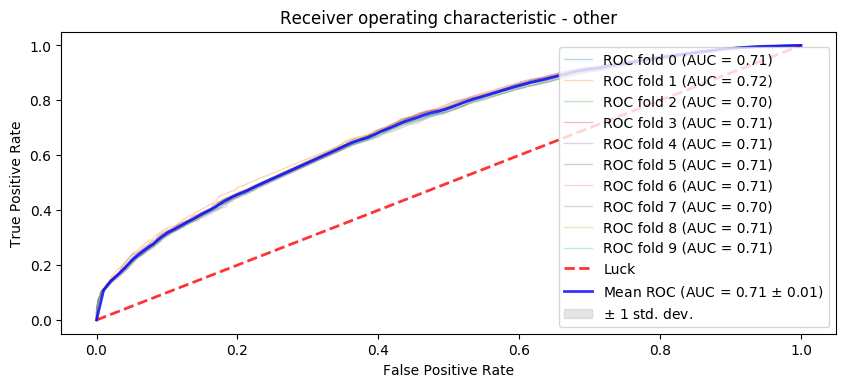

'Testing ransom...'

'ransom: 8939'

'not ransom: 145706'

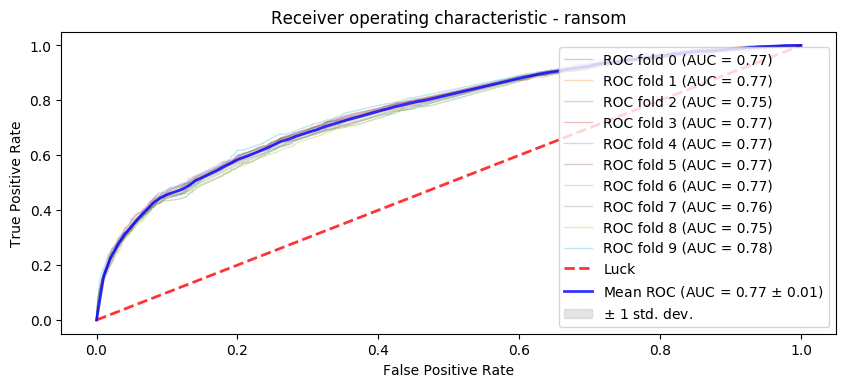

'Testing spyware...'

'spyware: 22994'

'not spyware: 131651'

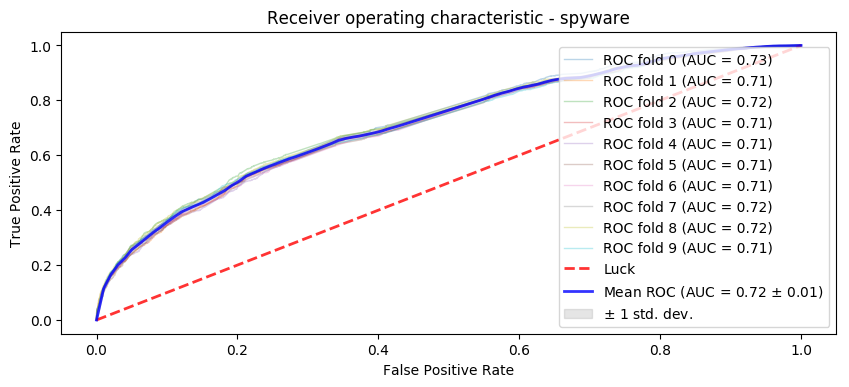

'Testing trojan...'

'trojan: 121394'

'not trojan: 33251'

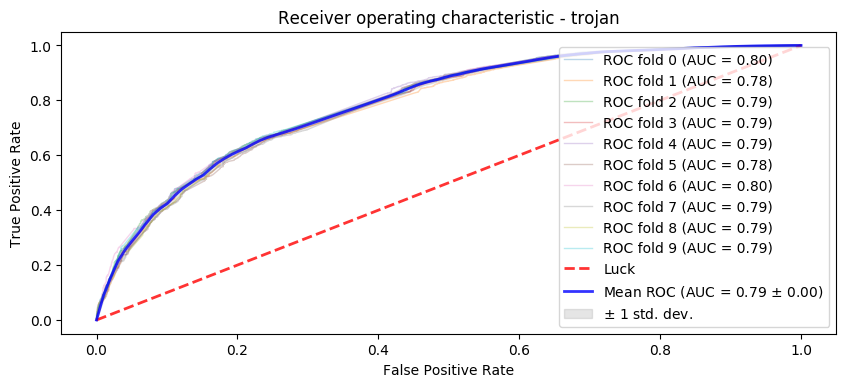

'Testing virus...'

'virus: 23063'

'not virus: 131582'

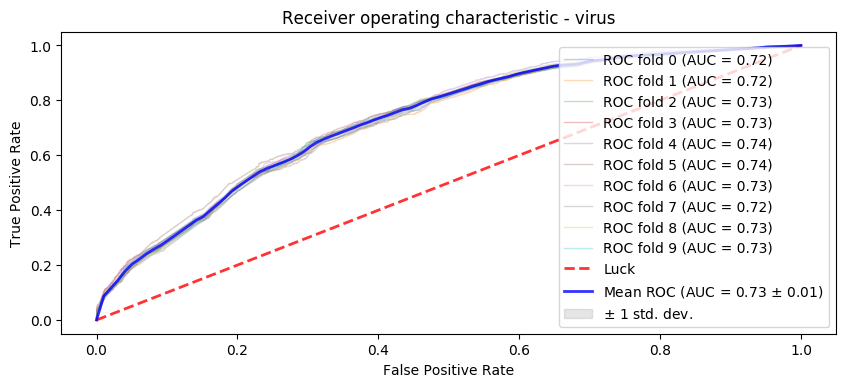

'Testing worm...'

'worm: 25528'

'not worm: 129117'

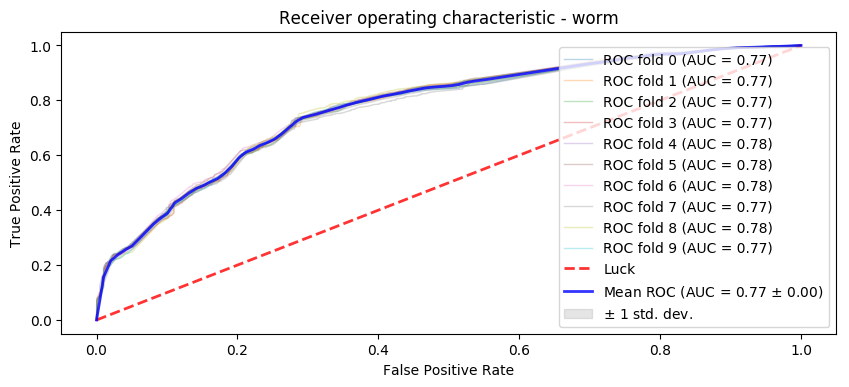

CPU times: user 2min 24s, sys: 2.09 s, total: 2min 26s
Wall time: 2min 23s


In [8]:
%%time
classifiers = dict()
final_rocs = dict()
for mclass in mal_classes:
    display('Testing {}...'.format(mclass))
        
    # Trying ROC
    skf = StratifiedKFold(n_splits=10)
    classifier = LogisticRegression(C=1)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    mal = big_dataset[big_dataset.index.isin(datasets[mclass])]
    not_mal = big_dataset[~big_dataset.index.isin(datasets[mclass])]
    not_mal.loc[:, 'is_malware'] = 0
    display('{}: {}'.format(mclass, len(mal)))
    display('not {}: {}'.format(mclass, len(not_mal)))
    
    assert len(mal) + len(not_mal) == len(big_dataset)
    
    data = shuffle(pd.concat([mal, not_mal]))
    X = cv.transform(data.imports)
    y = data.is_malware
    plt.figure(figsize=(10, 4), dpi=100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic - {}'.format(mclass))
    plt.legend(loc="lower right")
    plt.show()
    
    final_rocs[mclass] = (mean_fpr, mean_tpr)
    classifiers[mclass] = classifier.fit(X, y)

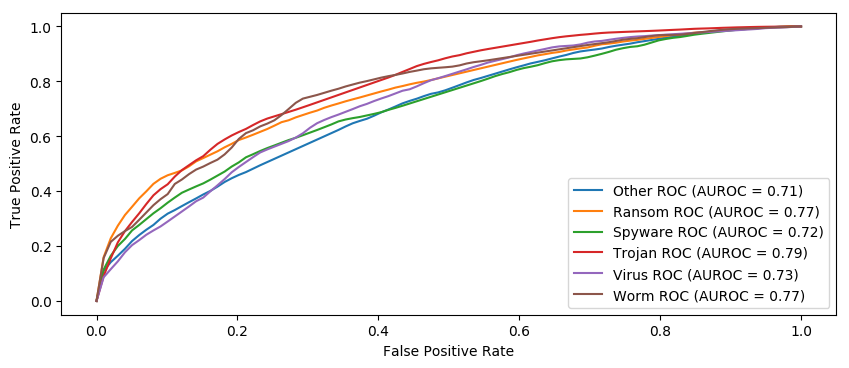

In [9]:
plt.figure(figsize=(10, 4), dpi=100)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
for mclass in mal_classes:
    plt.plot(final_rocs[mclass][0],
             final_rocs[mclass][1],
             label='{} ROC (AUROC = {:.2f})'.format(mclass.capitalize(), auc(final_rocs[mclass][0], final_rocs[mclass][1])))
plt.legend(loc="lower right")
plt.show()

# Malware/Goodware classifier

In [10]:
# Join to big_dataset classification from smaller classifiers
X = cv.transform(big_dataset.imports)
for mclass in mal_classes:
    probs = classifiers[mclass].predict_proba(X)[:,1]
    results = pd.DataFrame(index=big_dataset.index, data=classifiers[mclass].predict_proba(X)[:,1], columns=[mclass])
    big_dataset = big_dataset.join(results)
big_dataset.drop('imports', axis=1, inplace=True)

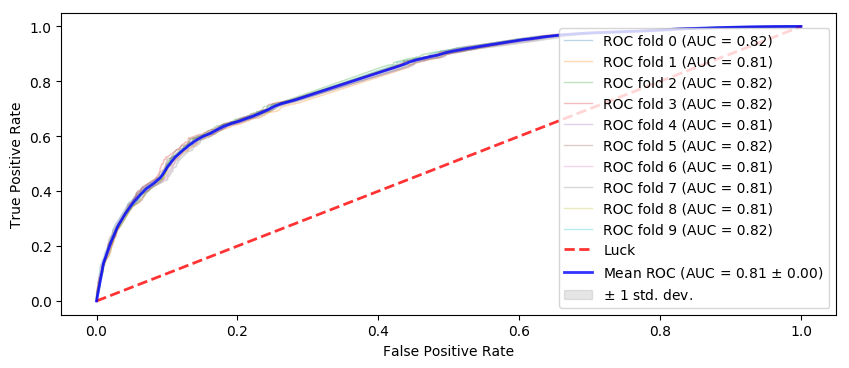

CPU times: user 4.6 s, sys: 6.51 s, total: 11.1 s
Wall time: 3.76 s


In [11]:
%%time
# Trying ROC
skf = StratifiedKFold(n_splits=10)
classifier = LogisticRegression(C=1)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
X = np.array(big_dataset.iloc[:, 1:])
y = big_dataset.is_malware
plt.figure(figsize=(10, 4), dpi=100)

i = 0
for train, test in skf.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic - TTS')
plt.legend(loc="lower right")
plt.show()